# Neural Network Project

*DSE student*, 
*Daria Shcherbakova*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import glob
import os
from PIL import Image

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss, roc_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, StratifiedKFold

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from keras_tuner import HyperModel, Hyperband, RandomSearch, Objective, HyperParameters

2023-07-31 13:01:04.087329: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data processing

In [2]:
train_dir = '/Users/svesh1971/Desktop/UNIMI/ML/train'
test_dir = '/Users/svesh1971/Desktop/UNIMI/ML/test'

train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

print("Train images:")
print(train_files)

print("\nTest images:")
print(test_files)

Train images:
['chihuahua', 'muffin']

Test images:
['chihuahua', 'muffin']


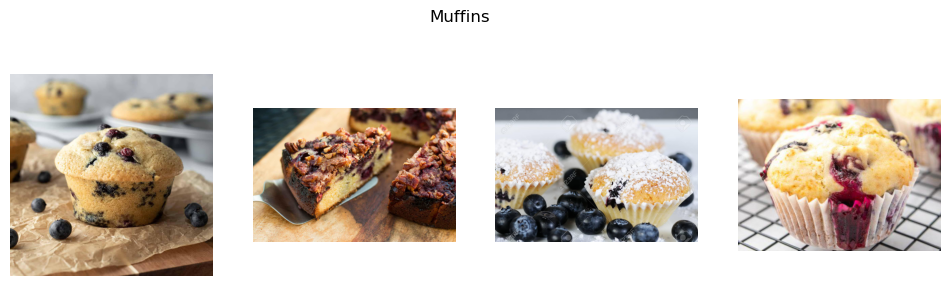

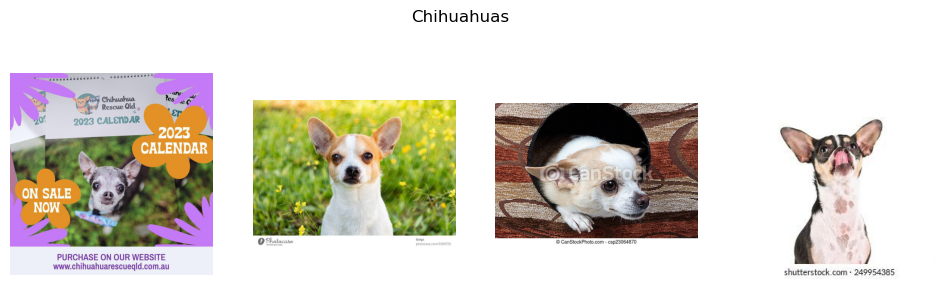

In [3]:
muffin = glob.glob(train_dir + "/muffin/*.jpg")
dog = glob.glob(train_dir + "/chihuahua/*.jpg")


if len(muffin) >= 4 & len(dog) >= 4:
    muffin = random.sample(muffin, 4)
    dog = random.sample(dog, 4)

    plt.figure(figsize=(12, 6))
    for i, path in enumerate(muffin):
        img = mpimg.imread(path)
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle('Muffins')
    plt.show()

    plt.figure(figsize=(12, 6))
    for i, path in enumerate(dog):
        img = mpimg.imread(path)
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle('Chihuahuas')
    plt.show()

In [4]:
image_size = (64, 64)

In [5]:
def preprocess_image(image_path):
    with Image.open(image_path) as image:
        image = image.convert("RGB")
        image = image.resize(image_size)
        image_array = np.array(image)
        return image_array

In [6]:
def load_images(directory):
    X = []
    y = []
    categories = os.listdir(directory)
    for category in categories:
        category_dir = os.path.join(directory, category)
        if os.path.isdir(category_dir):
            for image_name in os.listdir(category_dir):
                image_path = os.path.join(category_dir, image_name)
                if os.path.isfile(image_path):
                    image_array = preprocess_image(image_path)
                    X.append(image_array)
                    label = 1 if category == 'chihuahua' else 0
                    y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [7]:
X_train, y_train = load_images(train_dir)
X_test, y_test = load_images(test_dir)

In [8]:
print("\nImage Format")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


Image Format
X_train shape: (4733, 64, 64, 3)
X_test shape: (1184, 64, 64, 3)


In [9]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [10]:
print("\nPixel Value Range")
print("X_train min:", np.min(X_train))
print("X_train max:", np.max(X_train))
print("X_test min:", np.min(X_test))  
print("X_test max:", np.max(X_test))


Pixel Value Range
X_train min: 0.0
X_train max: 1.0
X_test min: 0.0
X_test max: 1.0


## CNN

### The first architecture

In [11]:
# feature extraction
model0 = Sequential()
model0.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model0.add(MaxPool2D((2, 2)))
# classification
model0.add(Flatten())
model0.add(Dense(1, activation='sigmoid'))

In [12]:
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 30752)             0         
                                                                 
 dense (Dense)               (None, 1)                 30753     
                                                                 
Total params: 31649 (123.63 KB)
Trainable params: 31649 (123.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model0.compile(optimizer="adam",
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [14]:
X_train1, X_validation, y_train1, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [15]:
history0 = model0.fit(X_train1, y_train1, epochs=10, batch_size=32, verbose=1,
                      validation_data = (X_validation, y_validation))

Epoch 1/10
119/119 [==============================] - 8s 56ms/step - loss: 0.5618 - accuracy: 0.7142 - precision: 0.7326 - recall: 0.7489 - val_loss: 0.4103 - val_accuracy: 0.8374 - val_precision: 0.8366 - val_recall: 0.8569
Epoch 2/10
119/119 [==============================] - 6s 53ms/step - loss: 0.3809 - accuracy: 0.8352 - precision: 0.8448 - recall: 0.8546 - val_loss: 0.3935 - val_accuracy: 0.8332 - val_precision: 0.7780 - val_recall: 0.9536
Epoch 3/10
119/119 [==============================] - 7s 60ms/step - loss: 0.3373 - accuracy: 0.8605 - precision: 0.8619 - recall: 0.8861 - val_loss: 0.3588 - val_accuracy: 0.8522 - val_precision: 0.8724 - val_recall: 0.8407
Epoch 4/10
119/119 [==============================] - 6s 48ms/step - loss: 0.3150 - accuracy: 0.8695 - precision: 0.8788 - recall: 0.8822 - val_loss: 0.4074 - val_accuracy: 0.8194 - val_precision: 0.7592 - val_recall: 0.9597
Epoch 5/10
119/119 [==============================] - 6s 49ms/step - loss: 0.2624 - accuracy: 0.8978

In [16]:
train_loss, train_accuracy, train_precision, train_recall = model0.evaluate(X_train1, y_train1, verbose=0)

In [17]:
print(f'Train Loss: {train_loss:.4f}')
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Train Precision: {train_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')

Train Loss: 0.1563
Train Accuracy: 0.9448
Train Precision: 0.9098
Train Recall: 0.9976


In [28]:
validation_loss, validation_accuracy, validation_precision, validation_recall = model0.evaluate(X_validation, y_validation, verbose=0)

In [29]:
print(f'validation Loss: {validation_loss:.4f}')
print(f'validation Accuracy: {validation_accuracy:.4f}')
print(f'validation Precision: {validation_precision:.4f}')
print(f'validation Recall: {validation_recall:.4f}')

validation Loss: 0.4026
validation Accuracy: 0.8342
validation Precision: 0.7839
validation Recall: 0.9435


*change learning rate*

In [19]:
# feature extraction
model01 = Sequential()
model01.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model01.add(MaxPool2D((2, 2)))
# classification
model01.add(Flatten())
model01.add(Dense(1, activation='sigmoid'))

In [20]:
model01.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [21]:
history01 = model01.fit(X_train1, y_train1, epochs=30, batch_size=32, verbose=1,  validation_data = (X_validation, y_validation))

Epoch 1/30
119/119 [==============================] - 7s 54ms/step - loss: 0.6429 - accuracy: 0.6326 - precision_1: 0.6280 - recall_1: 0.7988 - val_loss: 0.5766 - val_accuracy: 0.7244 - val_precision_1: 0.6880 - val_recall_1: 0.8669
Epoch 2/30
119/119 [==============================] - 7s 62ms/step - loss: 0.5494 - accuracy: 0.7462 - precision_1: 0.7631 - recall_1: 0.7746 - val_loss: 0.5269 - val_accuracy: 0.7381 - val_precision_1: 0.6851 - val_recall_1: 0.9254
Epoch 3/30
119/119 [==============================] - 7s 61ms/step - loss: 0.4943 - accuracy: 0.7898 - precision_1: 0.7984 - recall_1: 0.8216 - val_loss: 0.4647 - val_accuracy: 0.8099 - val_precision_1: 0.8185 - val_recall_1: 0.8185
Epoch 4/30
119/119 [==============================] - 7s 57ms/step - loss: 0.4600 - accuracy: 0.8125 - precision_1: 0.8238 - recall_1: 0.8342 - val_loss: 0.4413 - val_accuracy: 0.8237 - val_precision_1: 0.8283 - val_recall_1: 0.8367
Epoch 5/30
119/119 [==============================] - 8s 65ms/step -

In [22]:
train_loss, train_accuracy, train_precision, train_recall = model01.evaluate(X_train1, y_train1, verbose=0)

In [23]:
print(f'Train Loss: {train_loss:.4f}')
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Train Precision: {train_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')

Train Loss: 0.2645
Train Accuracy: 0.8946
Train Precision: 0.9402
Train Recall: 0.8614


In [24]:
validation_loss, validation_accuracy, validation_precision, validation_recall = model01.evaluate(X_validation, y_validation, verbose=0)

In [25]:
print(f'validation Loss: {validation_loss:.4f}')
print(f'validation Accuracy: {validation_accuracy:.4f}')
print(f'validation Precision: {validation_precision:.4f}')
print(f'validation Recall: {validation_recall:.4f}')

validation Loss: 0.3409
validation Accuracy: 0.8490
validation Precision: 0.8732
validation Recall: 0.8327


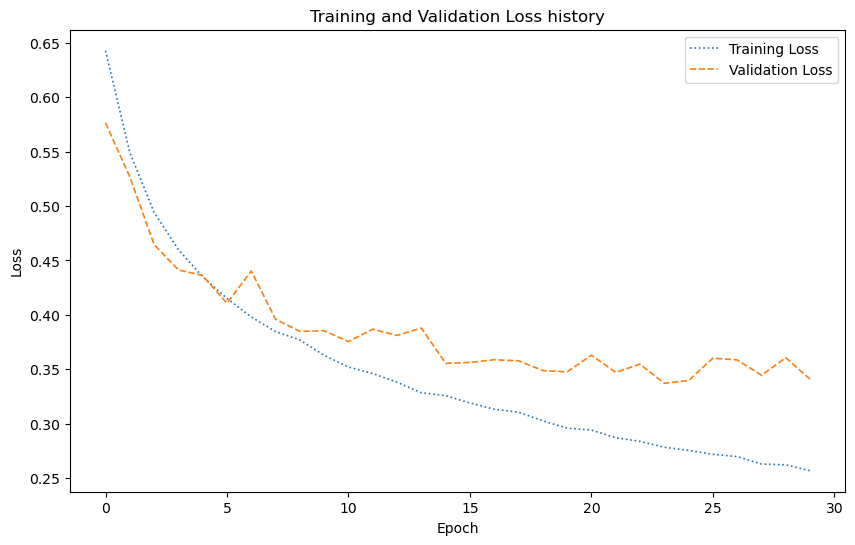

In [26]:
train_loss_history = history01.history['loss']
validation_loss_history = history01.history['val_loss']


plt.figure(figsize=(10, 6))

plt.plot(train_loss_history, label='Training Loss', linestyle=':', linewidth=1.2)
plt.plot(validation_loss_history, label='Validation Loss', linestyle='--', linewidth=1.2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss history')
plt.legend()
plt.grid(False)
plt.show()

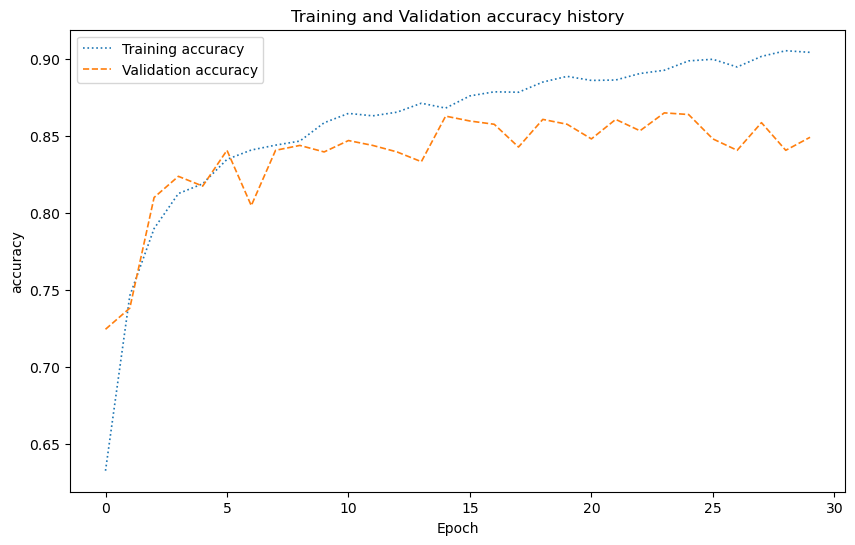

In [27]:
train_accuracy_history = history01.history['accuracy']
validation_accuracy_history = history01.history['val_accuracy']


plt.figure(figsize=(10, 6))

plt.plot(train_accuracy_history, label='Training accuracy', linestyle=':', linewidth=1.2)
plt.plot(validation_accuracy_history, label='Validation accuracy', linestyle='--', linewidth=1.2)
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training and Validation accuracy history')
plt.legend()
plt.grid(False)
plt.show()

#### 5-fold cross-validation

In [30]:
def create_model(image_size):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
    model.add(MaxPool2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [31]:
def zero_one_loss(y_true, y_pred):
    return tf.math.reduce_mean(tf.math.abs(y_true - tf.round(y_pred)))

In [32]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)
histories = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X_train, y_train)):
    print(f"Training on Fold {fold+1}...")
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]


    model = create_model(image_size)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), zero_one_loss])

    history = model.fit(X_train_fold, y_train_fold, epochs=15, batch_size=32, verbose=1,
                        validation_data= (X_val_fold, y_val_fold))
    histories.append(history)

Training on Fold 1...
Epoch 1/15
119/119 [==============================] - 8s 62ms/step - loss: 0.6423 - accuracy: 0.6355 - precision_2: 0.6368 - recall_2: 0.7582 - zero_one_loss: 0.3641 - val_loss: 0.5706 - val_accuracy: 0.7561 - val_precision_2: 0.7646 - val_recall_2: 0.7930 - val_zero_one_loss: 0.2463
Epoch 2/15
119/119 [==============================] - 8s 63ms/step - loss: 0.5602 - accuracy: 0.7322 - precision_2: 0.7454 - recall_2: 0.7665 - zero_one_loss: 0.2686 - val_loss: 0.5122 - val_accuracy: 0.7835 - val_precision_2: 0.7924 - val_recall_2: 0.8125 - val_zero_one_loss: 0.2185
Epoch 3/15
119/119 [==============================] - 7s 55ms/step - loss: 0.5145 - accuracy: 0.7618 - precision_2: 0.7743 - recall_2: 0.7894 - zero_one_loss: 0.2380 - val_loss: 0.4782 - val_accuracy: 0.8068 - val_precision_2: 0.8478 - val_recall_2: 0.7832 - val_zero_one_loss: 0.1949
Epoch 4/15
119/119 [==============================] - 6s 51ms/step - loss: 0.4794 - accuracy: 0.7866 - precision_2: 0.8032 

119/119 [==============================] - 9s 73ms/step - loss: 0.3108 - accuracy: 0.8822 - precision_3: 0.8825 - recall_3: 0.9023 - zero_one_loss: 0.1189 - val_loss: 0.3618 - val_accuracy: 0.8532 - val_precision_3: 0.8664 - val_recall_3: 0.8613 - val_zero_one_loss: 0.1469
Epoch 15/15
119/119 [==============================] - 8s 68ms/step - loss: 0.3048 - accuracy: 0.8833 - precision_3: 0.8805 - recall_3: 0.9072 - zero_one_loss: 0.1166 - val_loss: 0.3590 - val_accuracy: 0.8501 - val_precision_3: 0.8426 - val_recall_3: 0.8887 - val_zero_one_loss: 0.1501
Training on Fold 3...
Epoch 1/15
119/119 [==============================] - 11s 82ms/step - loss: 0.6252 - accuracy: 0.6479 - precision_4: 0.6517 - recall_4: 0.7494 - zero_one_loss: 0.3501 - val_loss: 0.5668 - val_accuracy: 0.7107 - val_precision_4: 0.6944 - val_recall_4: 0.8301 - val_zero_one_loss: 0.2904
Epoch 2/15
119/119 [==============================] - 10s 82ms/step - loss: 0.5182 - accuracy: 0.7647 - precision_4: 0.7881 - recall

Epoch 13/15
119/119 [==============================] - 8s 66ms/step - loss: 0.3521 - accuracy: 0.8566 - precision_5: 0.8561 - recall_5: 0.8832 - zero_one_loss: 0.1426 - val_loss: 0.3675 - val_accuracy: 0.8488 - val_precision_5: 0.8836 - val_recall_5: 0.8301 - val_zero_one_loss: 0.1522
Epoch 14/15
119/119 [==============================] - 8s 68ms/step - loss: 0.3435 - accuracy: 0.8656 - precision_5: 0.8690 - recall_5: 0.8847 - zero_one_loss: 0.1347 - val_loss: 0.4403 - val_accuracy: 0.7875 - val_precision_5: 0.7277 - val_recall_5: 0.9707 - val_zero_one_loss: 0.2183
Epoch 15/15
119/119 [==============================] - 8s 64ms/step - loss: 0.3411 - accuracy: 0.8643 - precision_5: 0.8662 - recall_5: 0.8857 - zero_one_loss: 0.1355 - val_loss: 0.3510 - val_accuracy: 0.8636 - val_precision_5: 0.8450 - val_recall_5: 0.9160 - val_zero_one_loss: 0.1392
Training on Fold 5...
Epoch 1/15
119/119 [==============================] - 10s 69ms/step - loss: 0.6309 - accuracy: 0.6578 - precision_6: 0.6

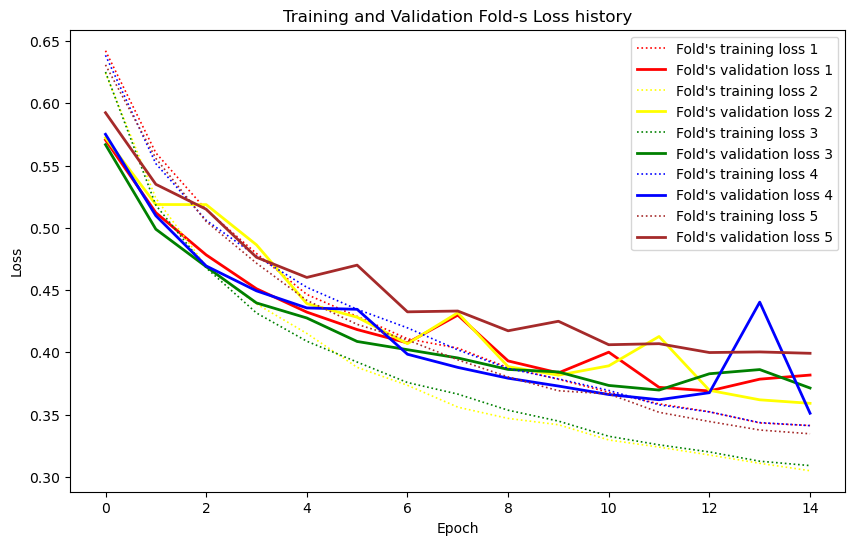

In [33]:
train_accuracies = []
validation_accuracies = []
colors = ['red', 'yellow', 'green', 'blue', 'brown']
i = 1
plt.figure(figsize=(10, 6))

for (history, color) in zip(histories, colors):
    plt.plot(history.history["loss"], label="Fold's training loss " + str(i) , linestyle=':', linewidth=1.2,color=color)
    plt.plot(history.history["val_loss"], label="Fold's validation loss " + str(i) , linestyle='-', linewidth=2,color=color)
    i += 1

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Fold-s Loss history')
plt.legend()
plt.grid(False)
plt.show()

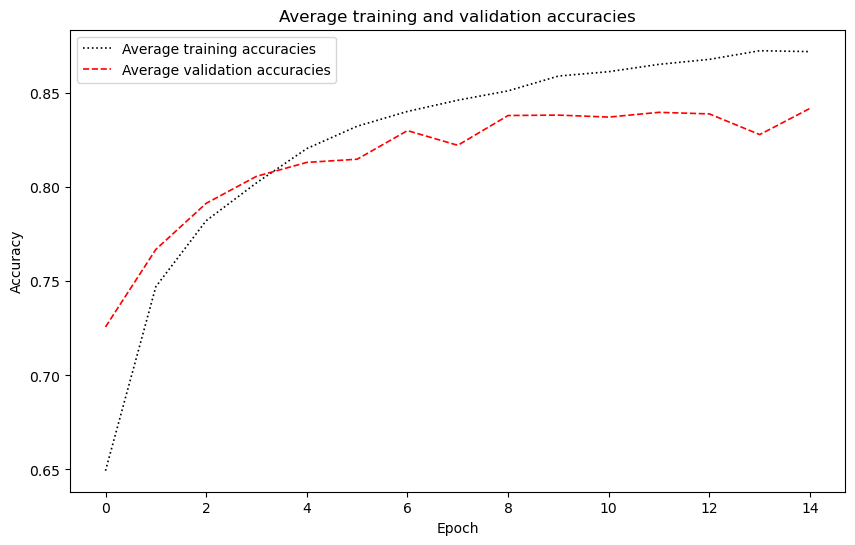

In [34]:
train_accuracies = []
validation_accuracies = []

for history in histories:
    train_accuracies.append(history.history['accuracy'])
    validation_accuracies.append(history.history['val_accuracy'])

matrix = np.array(train_accuracies)
train_mean_accuracies = np.mean(matrix, axis = 0)

matrix_val = np.array(validation_accuracies)
validation_mean_accuracies = np.mean(matrix_val, axis = 0)

plt.figure(figsize=(10, 6))

plt.plot(train_mean_accuracies, label='Average training accuracies', linestyle=':', linewidth=1.2,color='black')
plt.plot(validation_mean_accuracies, label='Average validation accuracies', linestyle='--', linewidth=1.2,color='red')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average training and validation accuracies')
plt.legend()
plt.grid(False)
plt.show()

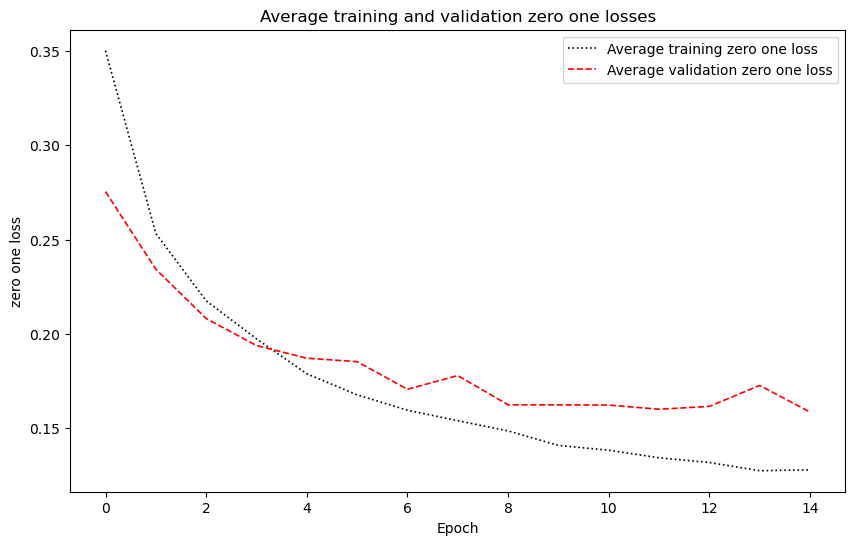

In [35]:
train_zero_one_losses = []
validation_zero_one_losses = []

for history in histories:
    train_zero_one_losses.append(history.history['zero_one_loss'])
    validation_zero_one_losses.append(history.history['val_zero_one_loss'])

matrix = np.array(train_zero_one_losses)
train_mean_loss = np.mean(matrix, axis = 0)

matrix_val = np.array(validation_zero_one_losses)
validation_mean_loss = np.mean(matrix_val, axis = 0)

plt.figure(figsize=(10, 6))

plt.plot(train_mean_loss, label='Average training zero one loss', linestyle=':', linewidth=1.2,color='black')
plt.plot(validation_mean_loss, label='Average validation zero one loss', linestyle='--', linewidth=1.2,color='red')


plt.xlabel('Epoch')
plt.ylabel('zero one loss')
plt.title('Average training and validation zero one losses')
plt.legend()
plt.grid(False)
plt.show()

### The second architecture

In [36]:
# feature extraction
model1 = Sequential()
model1.add(Conv2D(32, (5, 5), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Conv2D(16, (3, 3), activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))
# classification
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

In [37]:
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 3136)              0         
                                                                 
 dense_7 (Dense)             (None, 128)              

In [39]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [40]:
history1 = model1.fit(X_train1, y_train1, epochs=15, batch_size=32, verbose=1,  validation_data = (X_validation, y_validation))

Epoch 1/15
119/119 [==============================] - 19s 151ms/step - loss: 0.6409 - accuracy: 0.6302 - precision_8: 0.6223 - recall_8: 0.8177 - val_loss: 0.5695 - val_accuracy: 0.7371 - val_precision_8: 0.7300 - val_recall_8: 0.7903
Epoch 2/15
119/119 [==============================] - 16s 133ms/step - loss: 0.5500 - accuracy: 0.7293 - precision_8: 0.7453 - recall_8: 0.7644 - val_loss: 0.5446 - val_accuracy: 0.7170 - val_precision_8: 0.9014 - val_recall_8: 0.5161
Epoch 3/15
119/119 [==============================] - 17s 139ms/step - loss: 0.4936 - accuracy: 0.7662 - precision_8: 0.7948 - recall_8: 0.7698 - val_loss: 0.4494 - val_accuracy: 0.7973 - val_precision_8: 0.8439 - val_recall_8: 0.7520
Epoch 4/15
119/119 [==============================] - 17s 140ms/step - loss: 0.4262 - accuracy: 0.8133 - precision_8: 0.8370 - recall_8: 0.8163 - val_loss: 0.4123 - val_accuracy: 0.8215 - val_precision_8: 0.8238 - val_recall_8: 0.8387
Epoch 5/15
119/119 [==============================] - 14s 11

In [41]:
train_loss, train_accuracy, train_precision, train_recall = model1.evaluate(X_train1, y_train1, verbose=0)

In [42]:
print(f'Train Loss: {train_loss:.4f}')
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Train Precision: {train_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')

Train Loss: 0.2636
Train Accuracy: 0.8954
Train Precision: 0.8930
Train Recall: 0.9181


In [43]:
validation_loss, validation_accuracy, validation_precision, validation_recall = model1.evaluate(X_validation, y_validation, verbose=0)

In [44]:
print(f'validation Loss: {validation_loss:.4f}')
print(f'validation Accuracy: {validation_accuracy:.4f}')
print(f'validation Precision: {validation_precision:.4f}')
print(f'validation Recall: {validation_recall:.4f}')

validation Loss: 0.3422
validation Accuracy: 0.8596
validation Precision: 0.8380
validation Recall: 0.9073


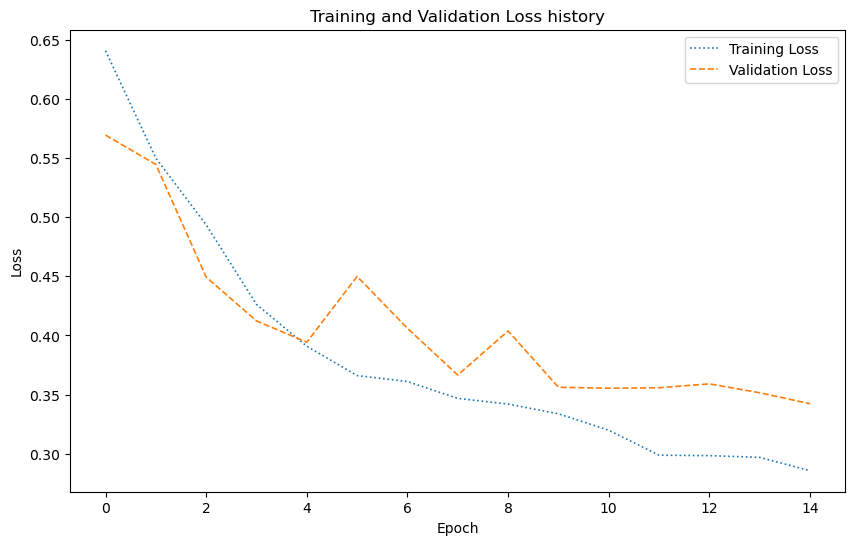

In [46]:
train_loss_history = history1.history['loss']
validation_loss_history = history1.history['val_loss']


plt.figure(figsize=(10, 6))

plt.plot(train_loss_history, label='Training Loss', linestyle=':', linewidth=1.2)
plt.plot(validation_loss_history, label='Validation Loss', linestyle='--', linewidth=1.2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss history')
plt.legend()
plt.grid(False)
plt.show()

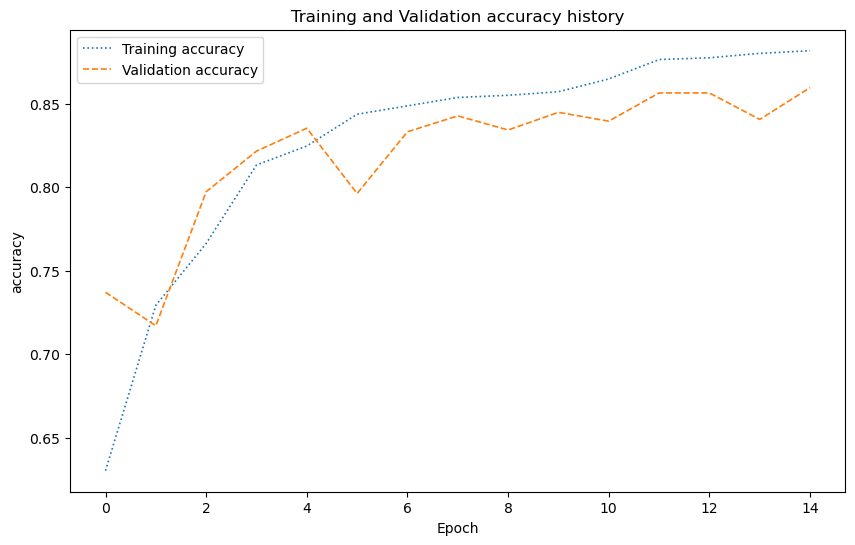

In [45]:
train_accuracy_history = history1.history['accuracy']
validation_accuracy_history = history1.history['val_accuracy']


plt.figure(figsize=(10, 6))

plt.plot(train_accuracy_history, label='Training accuracy', linestyle=':', linewidth=1.2)
plt.plot(validation_accuracy_history, label='Validation accuracy', linestyle='--', linewidth=1.2)
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training and Validation accuracy history')
plt.legend()
plt.grid(False)
plt.show()

#### 5-fold cross-validation

In [47]:
def create_model(image_size):
    model = Sequential()
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    # classification
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [48]:
histories = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X_train, y_train)):
    print(f"Training on Fold {fold+1}...")
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]


    model = create_model(image_size)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), zero_one_loss])

    history = model.fit(X_train_fold, y_train_fold, epochs=15, batch_size=32, verbose=1,
                        validation_data= (X_val_fold, y_val_fold))
    histories.append(history)

Training on Fold 1...
Epoch 1/15
119/119 [==============================] - 17s 130ms/step - loss: 0.6301 - accuracy: 0.6292 - precision_9: 0.6482 - recall_9: 0.6869 - zero_one_loss: 0.3722 - val_loss: 0.5828 - val_accuracy: 0.6758 - val_precision_9: 0.6395 - val_recall_9: 0.9180 - val_zero_one_loss: 0.3283
Epoch 2/15
119/119 [==============================] - 15s 126ms/step - loss: 0.5091 - accuracy: 0.7559 - precision_9: 0.7767 - recall_9: 0.7699 - zero_one_loss: 0.2432 - val_loss: 0.4592 - val_accuracy: 0.7941 - val_precision_9: 0.8644 - val_recall_9: 0.7344 - val_zero_one_loss: 0.2060
Epoch 3/15
119/119 [==============================] - 15s 124ms/step - loss: 0.4489 - accuracy: 0.7979 - precision_9: 0.8205 - recall_9: 0.8017 - zero_one_loss: 0.2009 - val_loss: 0.4500 - val_accuracy: 0.7941 - val_precision_9: 0.7536 - val_recall_9: 0.9199 - val_zero_one_loss: 0.2081
Epoch 4/15
119/119 [==============================] - 15s 128ms/step - loss: 0.4102 - accuracy: 0.8217 - precision_9:

119/119 [==============================] - 15s 129ms/step - loss: 0.2559 - accuracy: 0.8994 - precision_10: 0.8997 - recall_10: 0.9160 - zero_one_loss: 0.1024 - val_loss: 0.3341 - val_accuracy: 0.8606 - val_precision_10: 0.8785 - val_recall_10: 0.8613 - val_zero_one_loss: 0.1389
Epoch 15/15
119/119 [==============================] - 16s 135ms/step - loss: 0.2569 - accuracy: 0.8965 - precision_10: 0.8924 - recall_10: 0.9194 - zero_one_loss: 0.1041 - val_loss: 0.3400 - val_accuracy: 0.8543 - val_precision_10: 0.8304 - val_recall_10: 0.9180 - val_zero_one_loss: 0.1466
Training on Fold 3...
Epoch 1/15
119/119 [==============================] - 16s 123ms/step - loss: 0.6198 - accuracy: 0.6529 - precision_11: 0.6590 - recall_11: 0.7421 - zero_one_loss: 0.3468 - val_loss: 0.5526 - val_accuracy: 0.7159 - val_precision_11: 0.8423 - val_recall_11: 0.5840 - val_zero_one_loss: 0.2831
Epoch 2/15
119/119 [==============================] - 23s 194ms/step - loss: 0.4881 - accuracy: 0.7787 - precision_

119/119 [==============================] - 17s 143ms/step - loss: 0.2867 - accuracy: 0.8812 - precision_12: 0.8874 - recall_12: 0.8935 - zero_one_loss: 0.1182 - val_loss: 0.3239 - val_accuracy: 0.8700 - val_precision_12: 0.8442 - val_recall_12: 0.9316 - val_zero_one_loss: 0.1306
Epoch 13/15
119/119 [==============================] - 19s 155ms/step - loss: 0.2744 - accuracy: 0.8902 - precision_12: 0.8934 - recall_12: 0.9047 - zero_one_loss: 0.1092 - val_loss: 0.3446 - val_accuracy: 0.8605 - val_precision_12: 0.8156 - val_recall_12: 0.9590 - val_zero_one_loss: 0.1407
Epoch 14/15
119/119 [==============================] - 16s 133ms/step - loss: 0.2732 - accuracy: 0.8878 - precision_12: 0.8925 - recall_12: 0.9008 - zero_one_loss: 0.1126 - val_loss: 0.3126 - val_accuracy: 0.8679 - val_precision_12: 0.8512 - val_recall_12: 0.9160 - val_zero_one_loss: 0.1326
Epoch 15/15
119/119 [==============================] - 17s 144ms/step - loss: 0.2525 - accuracy: 0.8983 - precision_12: 0.9026 - recall_

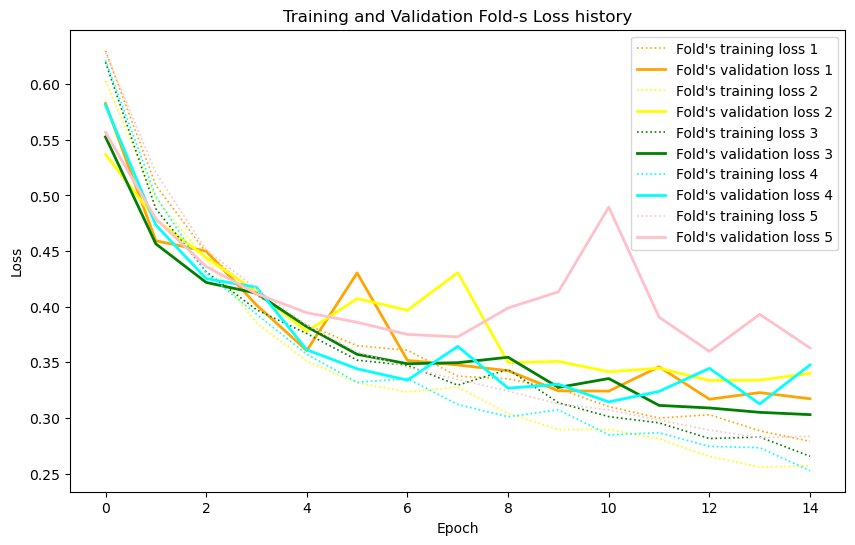

In [49]:
train_accuracies = []
validation_accuracies = []
colors = ['orange', 'yellow', 'green', 'cyan', 'pink']
i = 1
plt.figure(figsize=(10, 6))

for (history, color) in zip(histories, colors):
    plt.plot(history.history["loss"], label="Fold's training loss " + str(i) , linestyle=':', linewidth=1.2,color=color)
    plt.plot(history.history["val_loss"], label="Fold's validation loss " + str(i) , linestyle='-', linewidth=2,color=color)
    i += 1

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Fold-s Loss history')
plt.legend()
plt.grid(False)
plt.show()

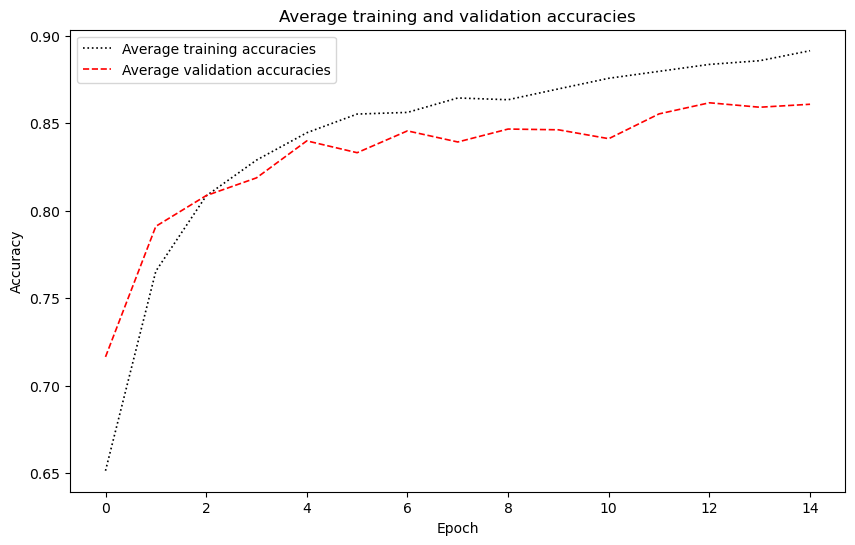

In [50]:
train_accuracies = []
validation_accuracies = []

for history in histories:
    train_accuracies.append(history.history['accuracy'])
    validation_accuracies.append(history.history['val_accuracy'])

matrix = np.array(train_accuracies)
train_mean_accuracies = np.mean(matrix, axis = 0)

matrix_val = np.array(validation_accuracies)
validation_mean_accuracies = np.mean(matrix_val, axis = 0)

plt.figure(figsize=(10, 6))

plt.plot(train_mean_accuracies, label='Average training accuracies', linestyle=':', linewidth=1.2,color='black')
plt.plot(validation_mean_accuracies, label='Average validation accuracies', linestyle='--', linewidth=1.2,color='red')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average training and validation accuracies')
plt.legend()
plt.grid(False)
plt.show()

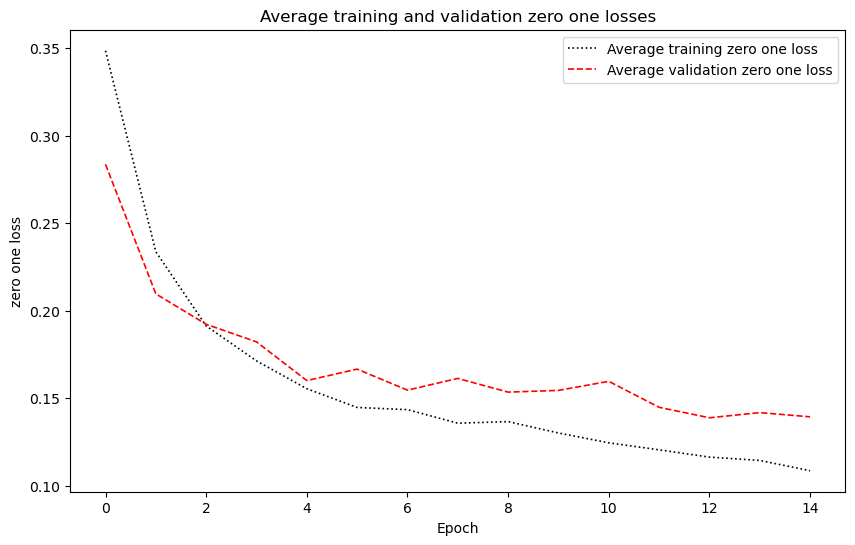

In [51]:
train_zero_one_losses = []
validation_zero_one_losses = []

for history in histories:
    train_zero_one_losses.append(history.history['zero_one_loss'])
    validation_zero_one_losses.append(history.history['val_zero_one_loss'])

matrix = np.array(train_zero_one_losses)
train_mean_loss = np.mean(matrix, axis = 0)

matrix_val = np.array(validation_zero_one_losses)
validation_mean_loss = np.mean(matrix_val, axis = 0)

plt.figure(figsize=(10, 6))

plt.plot(train_mean_loss, label='Average training zero one loss', linestyle=':', linewidth=1.2,color='black')
plt.plot(validation_mean_loss, label='Average validation zero one loss', linestyle='--', linewidth=1.2,color='red')


plt.xlabel('Epoch')
plt.ylabel('zero one loss')
plt.title('Average training and validation zero one losses')
plt.legend()
plt.grid(False)
plt.show()

### The third architecture

In [52]:
# feature extraction
model2 = Sequential()
model2.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
# classification
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

In [53]:
model2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 60, 60, 64)        4864      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 32)        18464     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 6272)              0         
                                                                 
 dense_19 (Dense)            (None, 256)             

In [54]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [55]:
history2 = model2.fit(X_train1, y_train1, epochs=15, batch_size=32, verbose=1,  validation_data = (X_validation, y_validation))

Epoch 1/15
119/119 [==============================] - 35s 278ms/step - loss: 0.6015 - accuracy: 0.6759 - precision_14: 0.6926 - recall_14: 0.7286 - val_loss: 0.5020 - val_accuracy: 0.7603 - val_precision_14: 0.8899 - val_recall_14: 0.6190
Epoch 2/15
119/119 [==============================] - 33s 278ms/step - loss: 0.4696 - accuracy: 0.7845 - precision_14: 0.8058 - recall_14: 0.7964 - val_loss: 0.4665 - val_accuracy: 0.7698 - val_precision_14: 0.9137 - val_recall_14: 0.6190
Epoch 3/15
119/119 [==============================] - 31s 258ms/step - loss: 0.4133 - accuracy: 0.8064 - precision_14: 0.8253 - recall_14: 0.8177 - val_loss: 0.3926 - val_accuracy: 0.8363 - val_precision_14: 0.8128 - val_recall_14: 0.8931
Epoch 4/15
119/119 [==============================] - 36s 305ms/step - loss: 0.3766 - accuracy: 0.8389 - precision_14: 0.8546 - recall_14: 0.8488 - val_loss: 0.3680 - val_accuracy: 0.8448 - val_precision_14: 0.8721 - val_recall_14: 0.8246
Epoch 5/15
119/119 [========================

In [56]:
train_loss, train_accuracy, train_precision, train_recall = model2.evaluate(X_train1, y_train1, verbose=0)

In [57]:
print(f'Train Loss: {train_loss:.4f}')
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Train Precision: {train_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')

Train Loss: 0.2682
Train Accuracy: 0.8825
Train Precision: 0.8313
Train Recall: 0.9840


In [58]:
validation_loss, validation_accuracy, validation_precision, validation_recall = model2.evaluate(X_validation, y_validation, verbose=0)

In [59]:
print(f'validation Loss: {validation_loss:.4f}')
print(f'validation Accuracy: {validation_accuracy:.4f}')
print(f'validation Precision: {validation_precision:.4f}')
print(f'validation Recall: {validation_recall:.4f}')

validation Loss: 0.3760
validation Accuracy: 0.8405
validation Precision: 0.7805
validation Recall: 0.9677


*upgrade with Early stopping*

In [60]:
# feature extraction
model3 = Sequential()
model3.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPool2D(pool_size=(2, 2)))
# classification
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))

In [61]:
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

In [62]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [63]:
history3 = model3.fit(X_train, y_train, epochs=15, batch_size=32, verbose=1,
                      validation_data = (X_validation, y_validation), callbacks=[early_stopping])

Epoch 1/15
148/148 [==============================] - 42s 269ms/step - loss: 0.5920 - accuracy: 0.6799 - precision_15: 0.6945 - recall_15: 0.7284 - val_loss: 0.4709 - val_accuracy: 0.8057 - val_precision_15: 0.7857 - val_recall_15: 0.8649
Epoch 2/15
148/148 [==============================] - 38s 257ms/step - loss: 0.4490 - accuracy: 0.8012 - precision_15: 0.8244 - recall_15: 0.8034 - val_loss: 0.3811 - val_accuracy: 0.8479 - val_precision_15: 0.8777 - val_recall_15: 0.8246
Epoch 3/15
148/148 [==============================] - 36s 247ms/step - loss: 0.3897 - accuracy: 0.8337 - precision_15: 0.8483 - recall_15: 0.8433 - val_loss: 0.3456 - val_accuracy: 0.8585 - val_precision_15: 0.8428 - val_recall_15: 0.8972
Epoch 4/15
148/148 [==============================] - 36s 240ms/step - loss: 0.3511 - accuracy: 0.8456 - precision_15: 0.8534 - recall_15: 0.8624 - val_loss: 0.3209 - val_accuracy: 0.8648 - val_precision_15: 0.8932 - val_recall_15: 0.8427
Epoch 5/15
148/148 [========================

In [64]:
train_loss, train_accuracy, train_precision, train_recall = model3.evaluate(X_train1, y_train1, verbose=0)

In [65]:
print(f'Train Loss: {train_loss:.4f}')
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Train Precision: {train_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')

Train Loss: 0.1770
Train Accuracy: 0.9324
Train Precision: 0.9284
Train Recall: 0.9491


In [67]:
validation_loss, validation_accuracy, validation_precision, validation_recall = model3.evaluate(X_validation, y_validation, verbose=0)

In [68]:
print(f'validation Loss: {validation_loss:.4f}')
print(f'validation Accuracy: {validation_accuracy:.4f}')
print(f'validation Precision: {validation_precision:.4f}')
print(f'validation Recall: {validation_recall:.4f}')

validation Loss: 0.1790
validation Accuracy: 0.9271
validation Precision: 0.9036
validation Recall: 0.9637


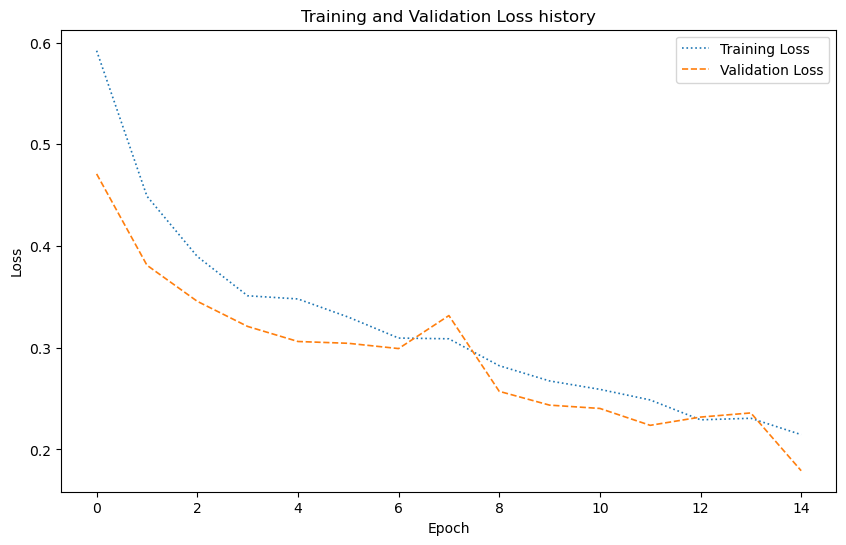

In [66]:
train_loss_history = history3.history['loss']
validation_loss_history = history3.history['val_loss']


plt.figure(figsize=(10, 6))

plt.plot(train_loss_history, label='Training Loss', linestyle=':', linewidth=1.2)
plt.plot(validation_loss_history, label='Validation Loss', linestyle='--', linewidth=1.2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss history')
plt.legend()
plt.grid(False)
plt.show()

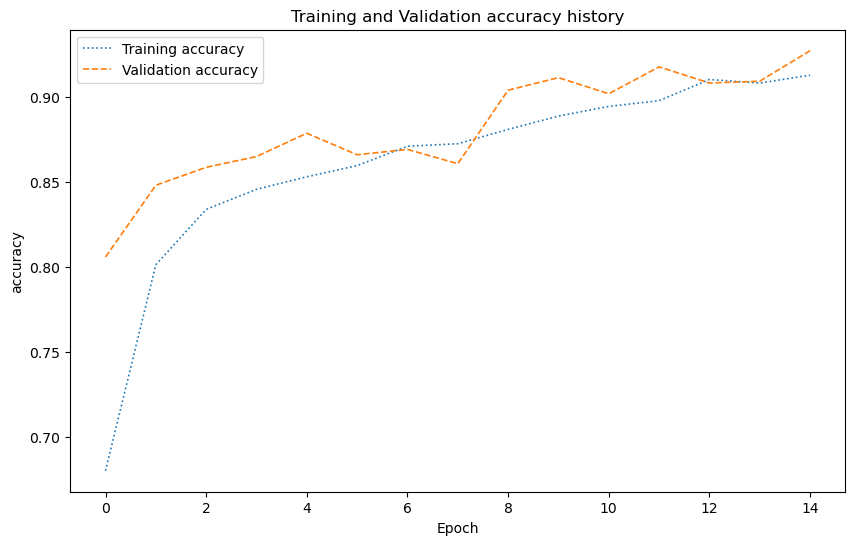

In [69]:
train_accuracy_history = history3.history['accuracy']
validation_accuracy_history = history3.history['val_accuracy']


plt.figure(figsize=(10, 6))

plt.plot(train_accuracy_history, label='Training accuracy', linestyle=':', linewidth=1.2)
plt.plot(validation_accuracy_history, label='Validation accuracy', linestyle='--', linewidth=1.2)
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training and Validation accuracy history')
plt.legend()
plt.grid(False)
plt.show()

#### 5-fold cross-validation

In [70]:
def model(image_size):
    model3 = Sequential()
    model3.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
    model3.add(MaxPool2D(pool_size=(2, 2)))
    model3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model3.add(MaxPool2D(pool_size=(2, 2)))
    model3.add(Flatten())
    model3.add(Dense(256, activation='relu'))
    model3.add(Dropout(0.5))
    model3.add(Dense(1, activation='sigmoid'))
    return model

In [71]:
histories = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X_train, y_train)):
    print(f"Training on Fold {fold+1}...")
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]


    model = create_model(image_size)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), zero_one_loss])

    history = model.fit(X_train_fold, y_train_fold, epochs=15, batch_size=32, verbose=1,
                        validation_data= (X_val_fold, y_val_fold))
    histories.append(history)

Training on Fold 1...
Epoch 1/15
119/119 [==============================] - 19s 145ms/step - loss: 0.6384 - accuracy: 0.6395 - precision_16: 0.6256 - recall_16: 0.8300 - zero_one_loss: 0.3608 - val_loss: 0.5254 - val_accuracy: 0.7687 - val_precision_16: 0.7749 - val_recall_16: 0.8066 - val_zero_one_loss: 0.2331
Epoch 2/15
119/119 [==============================] - 18s 153ms/step - loss: 0.4840 - accuracy: 0.7797 - precision_16: 0.8025 - recall_16: 0.7860 - zero_one_loss: 0.2202 - val_loss: 0.4351 - val_accuracy: 0.8131 - val_precision_16: 0.8051 - val_recall_16: 0.8633 - val_zero_one_loss: 0.1894
Epoch 3/15
119/119 [==============================] - 18s 152ms/step - loss: 0.4165 - accuracy: 0.8212 - precision_16: 0.8358 - recall_16: 0.8329 - zero_one_loss: 0.1789 - val_loss: 0.3985 - val_accuracy: 0.8342 - val_precision_16: 0.8817 - val_recall_16: 0.8008 - val_zero_one_loss: 0.1650
Epoch 4/15
119/119 [==============================] - 20s 171ms/step - loss: 0.3802 - accuracy: 0.8362 - 

Epoch 14/15
119/119 [==============================] - 14s 115ms/step - loss: 0.2891 - accuracy: 0.8862 - precision_17: 0.8938 - recall_17: 0.8959 - zero_one_loss: 0.1138 - val_loss: 0.3365 - val_accuracy: 0.8627 - val_precision_17: 0.8996 - val_recall_17: 0.8398 - val_zero_one_loss: 0.1397
Epoch 15/15
119/119 [==============================] - 13s 112ms/step - loss: 0.2768 - accuracy: 0.8851 - precision_17: 0.8897 - recall_17: 0.8989 - zero_one_loss: 0.1142 - val_loss: 0.3746 - val_accuracy: 0.8353 - val_precision_17: 0.7928 - val_recall_17: 0.9414 - val_zero_one_loss: 0.1682
Training on Fold 3...
Epoch 1/15
119/119 [==============================] - 15s 120ms/step - loss: 0.6131 - accuracy: 0.6770 - precision_18: 0.6831 - recall_18: 0.7509 - zero_one_loss: 0.3223 - val_loss: 0.5622 - val_accuracy: 0.7043 - val_precision_18: 0.6830 - val_recall_18: 0.8457 - val_zero_one_loss: 0.2967
Epoch 2/15
119/119 [==============================] - 14s 115ms/step - loss: 0.4921 - accuracy: 0.7726 

Epoch 12/15
119/119 [==============================] - 14s 117ms/step - loss: 0.3159 - accuracy: 0.8637 - precision_19: 0.8682 - recall_19: 0.8818 - zero_one_loss: 0.1360 - val_loss: 0.3280 - val_accuracy: 0.8594 - val_precision_19: 0.8529 - val_recall_19: 0.8945 - val_zero_one_loss: 0.1426
Epoch 13/15
119/119 [==============================] - 15s 129ms/step - loss: 0.3037 - accuracy: 0.8751 - precision_19: 0.8798 - recall_19: 0.8906 - zero_one_loss: 0.1262 - val_loss: 0.3228 - val_accuracy: 0.8594 - val_precision_19: 0.8582 - val_recall_19: 0.8867 - val_zero_one_loss: 0.1426
Epoch 14/15
119/119 [==============================] - 15s 125ms/step - loss: 0.2899 - accuracy: 0.8801 - precision_19: 0.8798 - recall_19: 0.9013 - zero_one_loss: 0.1217 - val_loss: 0.3186 - val_accuracy: 0.8615 - val_precision_19: 0.8574 - val_recall_19: 0.8926 - val_zero_one_loss: 0.1405
Epoch 15/15
119/119 [==============================] - 15s 125ms/step - loss: 0.2853 - accuracy: 0.8833 - precision_19: 0.88

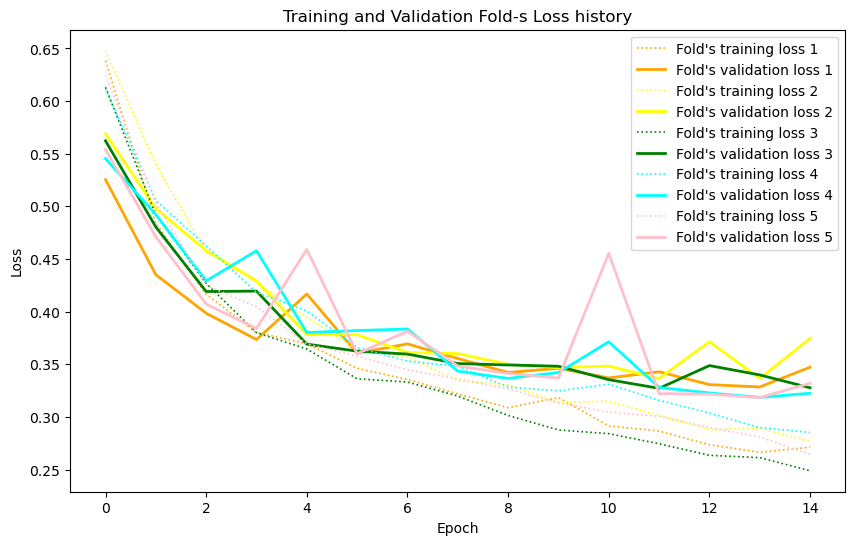

In [72]:
train_accuracies = []
validation_accuracies = []
colors = ['orange', 'yellow', 'green', 'cyan', 'pink']
i = 1
plt.figure(figsize=(10, 6))

for (history, color) in zip(histories, colors):
    plt.plot(history.history["loss"], label="Fold's training loss " + str(i) , linestyle=':', linewidth=1.2,color=color)
    plt.plot(history.history["val_loss"], label="Fold's validation loss " + str(i) , linestyle='-', linewidth=2,color=color)
    i += 1

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Fold-s Loss history')
plt.legend()
plt.grid(False)
plt.show()

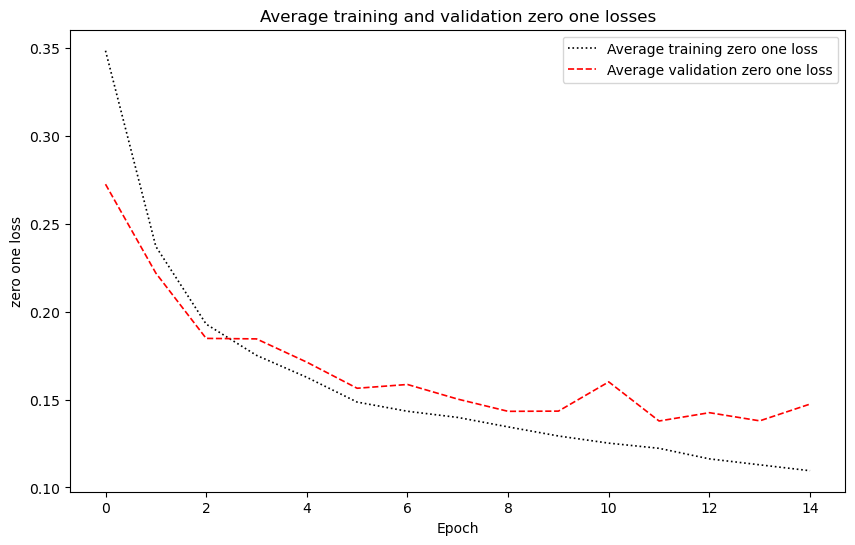

In [73]:
train_zero_one_losses = []
validation_zero_one_losses = []

for history in histories:
    train_zero_one_losses.append(history.history['zero_one_loss'])
    validation_zero_one_losses.append(history.history['val_zero_one_loss'])

matrix = np.array(train_zero_one_losses)
train_mean_loss = np.mean(matrix, axis = 0)

matrix_val = np.array(validation_zero_one_losses)
validation_mean_loss = np.mean(matrix_val, axis = 0)

plt.figure(figsize=(10, 6))

plt.plot(train_mean_loss, label='Average training zero one loss', linestyle=':', linewidth=1.2,color='black')
plt.plot(validation_mean_loss, label='Average validation zero one loss', linestyle='--', linewidth=1.2,color='red')


plt.xlabel('Epoch')
plt.ylabel('zero one loss')
plt.title('Average training and validation zero one losses')
plt.legend()
plt.grid(False)
plt.show()

## Model's tuning

In [81]:
def create_model(hp):
    # feature extraction
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('conv1_filter', min_value=16, max_value=128, step=16),
                     kernel_size=(5, 5), padding='valid', activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=hp.Int('conv2_filter', min_value=16, max_value=64, step=16),
                     kernel_size=(3, 3), padding='valid', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    # classification
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[zero_one_loss])
    return model

In [82]:
tuner = Hyperband(
    hypermodel=create_model,
    objective='val_loss',
    max_epochs=20,
    directory='/Users/svesh1971/Desktop/UNIMI/ML/',
    project_name='CNN'
)

In [83]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
conv1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
conv2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [84]:
tuner.search(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)

Trial 30 Complete [00h 09m 27s]
val_loss: 0.42344191670417786

Best val_loss So Far: 0.21296733617782593
Total elapsed time: 01h 47m 39s
INFO:tensorflow:Oracle triggered exit


In [160]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [161]:
search_results = tuner.results_summary()
print(search_results)

Results summary
Results in /Users/svesh1971/Desktop/UNIMI/ML/CNN
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0024 summary
Hyperparameters:
conv1_filter: 32
conv2_filter: 64
dense_units: 128
dropout_rate: 0.5
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020
Score: 0.21296733617782593

Trial 0005 summary
Hyperparameters:
conv1_filter: 64
conv2_filter: 48
dense_units: 256
dropout_rate: 0.3
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.24227000772953033

Trial 0012 summary
Hyperparameters:
conv1_filter: 64
conv2_filter: 48
dense_units: 256
dropout_rate: 0.3
tuner/epochs: 7
tuner/initial_epoch: 3
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0005
Score: 0.24605953693389893

Trial 0020 summary
Hyperparameters:
conv1_filter: 32
conv2_filter: 64
dense_units: 128
dropout_rate: 0.5
tuner/epochs: 7
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.2826695144176483

Trial 002

## Final model's fitting (on the whole training sample)

In [162]:
best_model = create_model(best_hyperparameters)

KeyError: 'filters1 does not exist.'

In [89]:
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss='binary_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), zero_one_loss])

In [90]:
history_tn = best_model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=1, callbacks=[early_stopping])

Epoch 1/7
148/148 [==============================] - 38s 245ms/step - loss: 0.5949 - accuracy: 0.6700 - precision: 0.6899 - recall: 0.7077 - zero_one_loss: 0.3300
Epoch 2/7
148/148 [==============================] - 46s 307ms/step - loss: 0.4790 - accuracy: 0.7782 - precision: 0.7995 - recall: 0.7870 - zero_one_loss: 0.2219
Epoch 3/7
148/148 [==============================] - 48s 324ms/step - loss: 0.4267 - accuracy: 0.8105 - precision: 0.8305 - recall: 0.8159 - zero_one_loss: 0.1894
Epoch 4/7
148/148 [==============================] - 48s 326ms/step - loss: 0.4042 - accuracy: 0.8234 - precision: 0.8439 - recall: 0.8261 - zero_one_loss: 0.1766
Epoch 5/7
148/148 [==============================] - 34s 232ms/step - loss: 0.3748 - accuracy: 0.8396 - precision: 0.8518 - recall: 0.8515 - zero_one_loss: 0.1604
Epoch 6/7
148/148 [==============================] - 47s 318ms/step - loss: 0.3733 - accuracy: 0.8432 - precision: 0.8578 - recall: 0.8511 - zero_one_loss: 0.1568
Epoch 7/7
148/148 [===

In [91]:
best_model.evaluate(X_train, y_train, verbose=0)

[0.3073427081108093,
 0.8740756511688232,
 0.8874852061271667,
 0.8784681558609009,
 0.12597565352916718]

## Prediction

In [92]:
test_results = best_model.evaluate(X_test, y_test)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])
print("Test Precision:", test_results[2])
print("Test Recall:", test_results[3])
print("Test Zero-one loss:", test_results[4])

37/37 [==============================] - 2s 46ms/step - loss: 0.3366 - accuracy: 0.8573 - precision: 0.8768 - recall: 0.8562 - zero_one_loss: 0.1427
Test Loss: 0.33661773800849915
Test Accuracy: 0.8572635054588318
Test Precision: 0.876800000667572
Test Recall: 0.856249988079071
Test Zero-one loss: 0.14273647964000702


In [94]:
from sklearn.metrics import classification_report
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
report = classification_report(y_test, y_pred)

print(report)

37/37 [==============================] - 2s 40ms/step
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       544
           1       0.88      0.86      0.87       640

    accuracy                           0.86      1184
   macro avg       0.86      0.86      0.86      1184
weighted avg       0.86      0.86      0.86      1184



## ✨ additional tuning✨

In [ ]:
import optuna

In [129]:
from sklearn.model_selection import train_test_split


X_train_subsample, X_validation, y_train_subsample, y_validation = train_test_split(X_train, y_train,
                                                                                    test_size=0.25,
                                                                                    random_state=42,
                                                                                    stratify=y_train)

print("X_train_subsample shape:", X_train_subsample.shape)
print("y_train_subsample shape:", y_train_subsample.shape)
print("X_validation shape:", X_validation.shape)
print("y_validation shape:", y_validation.shape)


X_train_subsample shape: (3549, 64, 64, 3)
y_train_subsample shape: (3549,)
X_validation shape: (1184, 64, 64, 3)
y_validation shape: (1184,)


In [142]:
def create_model(params):
    model = Sequential()

    model.add(
        Conv2D(filters=params['filters1'],
               kernel_size=(params['kernel_size1'], params['kernel_size1']),
               activation=params['activation'],
               input_shape=(64, 64, 3)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(
        Conv2D(filters=params['filters2'],
               kernel_size=(params['kernel_size2'], params['kernel_size2']),
               activation=params['activation'],
               input_shape=(64, 64, 3)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())

    if params['final_mlp_hidden_neurons'] > 0:
        model.add(Dense(params['final_mlp_hidden_neurons'], activation=params['activation']))

    model.add(Dropout(params['dropout']))

    model.add(Dense(1, activation='sigmoid'))
    return model

In [145]:
def objective(trial):
    params = {
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
        'filters1': trial.suggest_int('filters1', 16, 128, 16),
        'filters2': trial.suggest_int('filters2', 16, 128, 16),
        'kernel_size1': trial.suggest_int('kernel_size1', 3, 5, 2),
        'kernel_size2': trial.suggest_int('kernel_size21', 3, 5, 2),
        'final_mlp_hidden_neurons': trial.suggest_int('final_mlp_hidden_neurons', 0, 128, 16),
        'dropout': trial.suggest_float('dropout_rate', 0.0, 0.5),
    }
    model = create_model(params)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(X_train_subsample, y_train_subsample, epochs=20, batch_size=32, verbose=1,
                      validation_data = (X_validation, y_validation), callbacks=[early_stopping])
    final_loss = history.history['val_loss'][-1]
    print(history.history['val_loss'])
    return final_loss

In [146]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2023-07-31 20:27:35,430] A new study created in memory with name: no-name-22cadb78-0ba5-4e5a-87af-815e5f14936b


Epoch 1/20
111/111 [==============================] - 71s 632ms/step - loss: 0.6382 - accuracy: 0.6345 - val_loss: 0.5434 - val_accuracy: 0.7407
Epoch 2/20
111/111 [==============================] - 39s 350ms/step - loss: 0.5334 - accuracy: 0.7394 - val_loss: 0.4714 - val_accuracy: 0.7855
Epoch 3/20
111/111 [==============================] - 43s 385ms/step - loss: 0.4738 - accuracy: 0.7850 - val_loss: 0.4220 - val_accuracy: 0.8150
Epoch 4/20
111/111 [==============================] - 61s 550ms/step - loss: 0.4445 - accuracy: 0.7960 - val_loss: 0.3963 - val_accuracy: 0.8302
Epoch 5/20
111/111 [==============================] - 51s 460ms/step - loss: 0.4027 - accuracy: 0.8264 - val_loss: 0.3715 - val_accuracy: 0.8387
Epoch 6/20
111/111 [==============================] - 29s 265ms/step - loss: 0.3891 - accuracy: 0.8307 - val_loss: 0.3704 - val_accuracy: 0.8395
Epoch 7/20
111/111 [==============================] - 29s 260ms/step - loss: 0.3749 - accuracy: 0.8439 - val_loss: 0.3395 - val_ac

[I 2023-07-31 20:40:04,739] Trial 0 finished with value: 0.3947702944278717 and parameters: {'activation': 'relu', 'filters1': 96, 'filters2': 48, 'kernel_size1': 3, 'kernel_size21': 3, 'final_mlp_hidden_neurons': 16, 'dropout_rate': 0.17351945824554543}. Best is trial 0 with value: 0.3947702944278717.


[0.5433971285820007, 0.47139766812324524, 0.42198672890663147, 0.3962714970111847, 0.37149521708488464, 0.3704269528388977, 0.3395182490348816, 0.3351014256477356, 0.32176560163497925, 0.32639583945274353, 0.32073527574539185, 0.3230167329311371, 0.29966649413108826, 0.29925572872161865, 0.305483877658844, 0.30124494433403015, 0.2856382727622986, 0.2938981056213379, 0.277250736951828, 0.3947702944278717]
Epoch 1/20
111/111 [==============================] - 72s 645ms/step - loss: 0.5634 - accuracy: 0.6968 - val_loss: 0.4830 - val_accuracy: 0.7821
Epoch 2/20
111/111 [==============================] - 69s 622ms/step - loss: 0.4619 - accuracy: 0.7943 - val_loss: 0.4320 - val_accuracy: 0.8083
Epoch 3/20
111/111 [==============================] - 69s 625ms/step - loss: 0.4218 - accuracy: 0.8135 - val_loss: 0.4051 - val_accuracy: 0.8243
Epoch 4/20
111/111 [==============================] - 70s 632ms/step - loss: 0.3864 - accuracy: 0.8357 - val_loss: 0.4241 - val_accuracy: 0.8117
Epoch 5/20
1

[I 2023-07-31 21:05:06,102] Trial 1 finished with value: 0.39398834109306335 and parameters: {'activation': 'tanh', 'filters1': 112, 'filters2': 80, 'kernel_size1': 3, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 80, 'dropout_rate': 0.08302095080178257}. Best is trial 1 with value: 0.39398834109306335.


[0.4830050468444824, 0.43203040957450867, 0.40506187081336975, 0.4240861237049103, 0.3886350691318512, 0.3600630760192871, 0.48793256282806396, 0.36717239022254944, 0.352644145488739, 0.3528358042240143, 0.3544222414493561, 0.354923278093338, 0.37524881958961487, 0.36129167675971985, 0.37511494755744934, 0.36829137802124023, 0.372327595949173, 0.37094464898109436, 0.3755810856819153, 0.39398834109306335]
Epoch 1/20
111/111 [==============================] - 18s 152ms/step - loss: 0.6109 - accuracy: 0.6610 - val_loss: 0.5129 - val_accuracy: 0.7492
Epoch 2/20
111/111 [==============================] - 15s 132ms/step - loss: 0.5122 - accuracy: 0.7577 - val_loss: 0.4530 - val_accuracy: 0.7846
Epoch 3/20
111/111 [==============================] - 16s 147ms/step - loss: 0.4613 - accuracy: 0.7881 - val_loss: 0.4378 - val_accuracy: 0.8015
Epoch 4/20
111/111 [==============================] - 15s 134ms/step - loss: 0.4273 - accuracy: 0.8087 - val_loss: 0.3809 - val_accuracy: 0.8370
Epoch 5/20
1

[I 2023-07-31 21:13:31,487] Trial 2 finished with value: 0.29103589057922363 and parameters: {'activation': 'relu', 'filters1': 16, 'filters2': 64, 'kernel_size1': 5, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 64, 'dropout_rate': 0.3960838656689838}. Best is trial 2 with value: 0.29103589057922363.


[0.5128622055053711, 0.4530077874660492, 0.4378197193145752, 0.3808581531047821, 0.3796820640563965, 0.3561914265155792, 0.3482678532600403, 0.36993569135665894, 0.3379799723625183, 0.33831313252449036, 0.3422800302505493, 0.3275112509727478, 0.34717437624931335, 0.3123660683631897, 0.30618152022361755, 0.32703354954719543, 0.2976089119911194, 0.29791027307510376, 0.2965531051158905, 0.29103589057922363]
Epoch 1/20
111/111 [==============================] - 71s 615ms/step - loss: 0.6324 - accuracy: 0.6357 - val_loss: 0.5245 - val_accuracy: 0.7601
Epoch 2/20
111/111 [==============================] - 58s 524ms/step - loss: 0.5170 - accuracy: 0.7551 - val_loss: 0.4661 - val_accuracy: 0.7821
Epoch 3/20
111/111 [==============================] - 62s 557ms/step - loss: 0.4339 - accuracy: 0.8078 - val_loss: 0.3739 - val_accuracy: 0.8412
Epoch 4/20
111/111 [==============================] - 70s 629ms/step - loss: 0.3879 - accuracy: 0.8360 - val_loss: 0.4095 - val_accuracy: 0.8260
Epoch 5/20
1

[I 2023-07-31 21:31:39,495] Trial 3 finished with value: 0.2783062160015106 and parameters: {'activation': 'relu', 'filters1': 64, 'filters2': 96, 'kernel_size1': 5, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 16, 'dropout_rate': 0.14875262442789094}. Best is trial 3 with value: 0.2783062160015106.


[0.5244514346122742, 0.46610480546951294, 0.37390071153640747, 0.4094574749469757, 0.35264113545417786, 0.32322198152542114, 0.31629347801208496, 0.32997584342956543, 0.34266477823257446, 0.35225898027420044, 0.3300924003124237, 0.317791223526001, 0.28647205233573914, 0.2851499319076538, 0.30507388710975647, 0.30201590061187744, 0.2754960060119629, 0.273321270942688, 0.2769804894924164, 0.2783062160015106]
Epoch 1/20
111/111 [==============================] - 58s 509ms/step - loss: 0.5994 - accuracy: 0.6720 - val_loss: 0.4975 - val_accuracy: 0.7568
Epoch 2/20
111/111 [==============================] - 53s 478ms/step - loss: 0.4810 - accuracy: 0.7777 - val_loss: 0.4136 - val_accuracy: 0.8269
Epoch 3/20
111/111 [==============================] - 61s 554ms/step - loss: 0.4065 - accuracy: 0.8242 - val_loss: 0.3896 - val_accuracy: 0.8260
Epoch 4/20
111/111 [==============================] - 83s 751ms/step - loss: 0.3745 - accuracy: 0.8411 - val_loss: 0.3768 - val_accuracy: 0.8361
Epoch 5/20

[I 2023-07-31 21:51:50,346] Trial 4 finished with value: 0.2672388255596161 and parameters: {'activation': 'relu', 'filters1': 112, 'filters2': 128, 'kernel_size1': 3, 'kernel_size21': 3, 'final_mlp_hidden_neurons': 32, 'dropout_rate': 0.11475909416266933}. Best is trial 4 with value: 0.2672388255596161.


[0.4975052773952484, 0.4136008024215698, 0.3896164894104004, 0.37678784132003784, 0.33943453431129456, 0.32586556673049927, 0.3066781461238861, 0.3229648172855377, 0.29175347089767456, 0.28850674629211426, 0.2888968586921692, 0.2746204435825348, 0.3040961027145386, 0.2836934030056, 0.2857702076435089, 0.2784196436405182, 0.2627088725566864, 0.26499873399734497, 0.26071932911872864, 0.2672388255596161]
Epoch 1/20
111/111 [==============================] - 66s 586ms/step - loss: 0.5945 - accuracy: 0.6903 - val_loss: 0.4859 - val_accuracy: 0.7821
Epoch 2/20
111/111 [==============================] - 63s 569ms/step - loss: 0.4922 - accuracy: 0.7611 - val_loss: 0.4126 - val_accuracy: 0.8252
Epoch 3/20
111/111 [==============================] - 62s 556ms/step - loss: 0.4113 - accuracy: 0.8183 - val_loss: 0.3934 - val_accuracy: 0.8277
Epoch 4/20
111/111 [==============================] - 61s 554ms/step - loss: 0.3770 - accuracy: 0.8380 - val_loss: 0.3392 - val_accuracy: 0.8623
Epoch 5/20
111/

[I 2023-07-31 22:12:53,718] Trial 5 finished with value: 0.3031863272190094 and parameters: {'activation': 'relu', 'filters1': 128, 'filters2': 128, 'kernel_size1': 5, 'kernel_size21': 3, 'final_mlp_hidden_neurons': 96, 'dropout_rate': 0.15703140794071174}. Best is trial 4 with value: 0.2672388255596161.


[0.4858838617801666, 0.41258925199508667, 0.3933814465999603, 0.33921951055526733, 0.4540438652038574, 0.3274454176425934, 0.3198326826095581, 0.30941393971443176, 0.3055788576602936, 0.3084346652030945, 0.3309987783432007, 0.30353379249572754, 0.2942894399166107, 0.32374826073646545, 0.29043492674827576, 0.28674569725990295, 0.2892299294471741, 0.27925121784210205, 0.28876155614852905, 0.3031863272190094]
Epoch 1/20
111/111 [==============================] - 41s 360ms/step - loss: 0.5670 - accuracy: 0.7084 - val_loss: 0.4890 - val_accuracy: 0.7880
Epoch 2/20
111/111 [==============================] - 40s 360ms/step - loss: 0.4611 - accuracy: 0.7926 - val_loss: 0.4339 - val_accuracy: 0.8074
Epoch 3/20
111/111 [==============================] - 41s 371ms/step - loss: 0.4263 - accuracy: 0.8177 - val_loss: 0.4211 - val_accuracy: 0.8184
Epoch 4/20
111/111 [==============================] - 39s 353ms/step - loss: 0.3897 - accuracy: 0.8405 - val_loss: 0.4213 - val_accuracy: 0.8201
Epoch 5/20

[I 2023-07-31 22:26:56,213] Trial 6 finished with value: 0.40406161546707153 and parameters: {'activation': 'tanh', 'filters1': 96, 'filters2': 80, 'kernel_size1': 5, 'kernel_size21': 3, 'final_mlp_hidden_neurons': 64, 'dropout_rate': 0.11772753589554574}. Best is trial 4 with value: 0.2672388255596161.


[0.48897042870521545, 0.43389371037483215, 0.4211256802082062, 0.42131176590919495, 0.38367655873298645, 0.36391913890838623, 0.3777487874031067, 0.36416012048721313, 0.35281461477279663, 0.3726450502872467, 0.34711962938308716, 0.3559562861919403, 0.3720395267009735, 0.36113405227661133, 0.42931845784187317, 0.36964550614356995, 0.3781484365463257, 0.3935137987136841, 0.40311211347579956, 0.40406161546707153]
Epoch 1/20
111/111 [==============================] - 43s 374ms/step - loss: 0.5611 - accuracy: 0.7067 - val_loss: 0.4590 - val_accuracy: 0.7931
Epoch 2/20
111/111 [==============================] - 44s 397ms/step - loss: 0.4404 - accuracy: 0.8036 - val_loss: 0.4181 - val_accuracy: 0.8125
Epoch 3/20
111/111 [==============================] - 42s 381ms/step - loss: 0.4072 - accuracy: 0.8292 - val_loss: 0.4054 - val_accuracy: 0.8252
Epoch 4/20
111/111 [==============================] - 41s 366ms/step - loss: 0.3679 - accuracy: 0.8484 - val_loss: 0.3752 - val_accuracy: 0.8480
Epoch 

[I 2023-07-31 22:40:50,605] Trial 7 finished with value: 0.40731438994407654 and parameters: {'activation': 'tanh', 'filters1': 96, 'filters2': 96, 'kernel_size1': 3, 'kernel_size21': 3, 'final_mlp_hidden_neurons': 112, 'dropout_rate': 0.06384911902366336}. Best is trial 4 with value: 0.2672388255596161.


[0.4590161442756653, 0.4181160032749176, 0.40544986724853516, 0.3752199113368988, 0.3556966185569763, 0.36144760251045227, 0.3634036183357239, 0.35298261046409607, 0.3416318893432617, 0.350023090839386, 0.3720620274543762, 0.34477341175079346, 0.38112756609916687, 0.34158435463905334, 0.37284034490585327, 0.35840103030204773, 0.3661959767341614, 0.40631893277168274, 0.3933892846107483, 0.40731438994407654]
Epoch 1/20
111/111 [==============================] - 35s 305ms/step - loss: 0.5516 - accuracy: 0.7177 - val_loss: 0.4843 - val_accuracy: 0.7770
Epoch 2/20
111/111 [==============================] - 33s 301ms/step - loss: 0.4621 - accuracy: 0.7918 - val_loss: 0.4254 - val_accuracy: 0.8125
Epoch 3/20
111/111 [==============================] - 33s 297ms/step - loss: 0.4225 - accuracy: 0.8121 - val_loss: 0.4036 - val_accuracy: 0.8252
Epoch 4/20
111/111 [==============================] - 33s 298ms/step - loss: 0.3856 - accuracy: 0.8388 - val_loss: 0.3941 - val_accuracy: 0.8361
Epoch 5/20

[I 2023-07-31 22:51:54,109] Trial 8 finished with value: 0.3891395032405853 and parameters: {'activation': 'tanh', 'filters1': 48, 'filters2': 80, 'kernel_size1': 3, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 32, 'dropout_rate': 0.003176596081871097}. Best is trial 4 with value: 0.2672388255596161.


[0.4842735528945923, 0.42539161443710327, 0.40359506011009216, 0.3940773606300354, 0.38796815276145935, 0.3772243559360504, 0.36018311977386475, 0.35216599702835083, 0.3668287992477417, 0.3578013777732849, 0.3561830520629883, 0.34201252460479736, 0.352605938911438, 0.3824025094509125, 0.34991177916526794, 0.35590463876724243, 0.3456183671951294, 0.35023564100265503, 0.34928280115127563, 0.3891395032405853]
Epoch 1/20
111/111 [==============================] - 17s 141ms/step - loss: 0.6665 - accuracy: 0.5779 - val_loss: 0.6111 - val_accuracy: 0.6993
Epoch 2/20
111/111 [==============================] - 15s 138ms/step - loss: 0.5990 - accuracy: 0.6760 - val_loss: 0.5499 - val_accuracy: 0.7618
Epoch 3/20
111/111 [==============================] - 16s 147ms/step - loss: 0.5473 - accuracy: 0.7334 - val_loss: 0.5057 - val_accuracy: 0.7669
Epoch 4/20
111/111 [==============================] - 15s 137ms/step - loss: 0.5282 - accuracy: 0.7563 - val_loss: 0.4778 - val_accuracy: 0.7855
Epoch 5/20

[I 2023-07-31 22:57:05,353] Trial 9 finished with value: 0.3286651372909546 and parameters: {'activation': 'relu', 'filters1': 32, 'filters2': 80, 'kernel_size1': 3, 'kernel_size21': 3, 'final_mlp_hidden_neurons': 16, 'dropout_rate': 0.4967585902837306}. Best is trial 4 with value: 0.2672388255596161.


[0.6110968589782715, 0.5499131679534912, 0.5057486891746521, 0.4777747392654419, 0.4375385046005249, 0.4471879303455353, 0.40967777371406555, 0.4310666024684906, 0.38940516114234924, 0.410556435585022, 0.3942137062549591, 0.3584144115447998, 0.36503949761390686, 0.3493565618991852, 0.3439740538597107, 0.38532695174217224, 0.3393896520137787, 0.33811941742897034, 0.34875839948654175, 0.3286651372909546]
Epoch 1/20
111/111 [==============================] - 36s 312ms/step - loss: 0.6450 - accuracy: 0.6250 - val_loss: 0.5439 - val_accuracy: 0.7466
Epoch 2/20
111/111 [==============================] - 35s 313ms/step - loss: 0.5269 - accuracy: 0.7515 - val_loss: 0.4611 - val_accuracy: 0.7914
Epoch 3/20
111/111 [==============================] - 37s 335ms/step - loss: 0.4615 - accuracy: 0.7912 - val_loss: 0.4171 - val_accuracy: 0.8091
Epoch 4/20
111/111 [==============================] - 36s 326ms/step - loss: 0.4050 - accuracy: 0.8267 - val_loss: 0.3731 - val_accuracy: 0.8429
Epoch 5/20
111

[I 2023-07-31 23:07:09,930] Trial 10 finished with value: 0.2997003495693207 and parameters: {'activation': 'relu', 'filters1': 128, 'filters2': 16, 'kernel_size1': 3, 'kernel_size21': 3, 'final_mlp_hidden_neurons': 48, 'dropout_rate': 0.2650570241733637}. Best is trial 4 with value: 0.2672388255596161.


[0.5439045429229736, 0.4610815942287445, 0.41709432005882263, 0.3731361925601959, 0.41588351130485535, 0.37833529710769653, 0.35317081212997437, 0.34474337100982666, 0.36715999245643616, 0.36157914996147156, 0.3166988790035248, 0.3452814817428589, 0.3077676296234131, 0.3031766712665558, 0.3029939830303192, 0.2969372868537903, 0.2997003495693207]
Epoch 1/20
111/111 [==============================] - 56s 500ms/step - loss: 0.6257 - accuracy: 0.6588 - val_loss: 0.5412 - val_accuracy: 0.7188
Epoch 2/20
111/111 [==============================] - 58s 528ms/step - loss: 0.5214 - accuracy: 0.7475 - val_loss: 0.4939 - val_accuracy: 0.7796
Epoch 3/20
111/111 [==============================] - 59s 527ms/step - loss: 0.4769 - accuracy: 0.7802 - val_loss: 0.4264 - val_accuracy: 0.8167
Epoch 4/20
111/111 [==============================] - 55s 500ms/step - loss: 0.4267 - accuracy: 0.8045 - val_loss: 0.3926 - val_accuracy: 0.8387
Epoch 5/20
111/111 [==============================] - 56s 507ms/step - l

[I 2023-07-31 23:29:45,333] Trial 11 finished with value: 0.28382861614227295 and parameters: {'activation': 'relu', 'filters1': 64, 'filters2': 128, 'kernel_size1': 5, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 0, 'dropout_rate': 0.22474315903845507}. Best is trial 4 with value: 0.2672388255596161.


[0.5412382483482361, 0.49385708570480347, 0.4264304041862488, 0.39263448119163513, 0.35996323823928833, 0.34708625078201294, 0.3468218743801117, 0.32564204931259155, 0.3254423141479492, 0.3225608468055725, 0.3141404688358307, 0.3165029287338257, 0.30563825368881226, 0.32054775953292847, 0.39794477820396423, 0.2970273494720459, 0.3153364360332489, 0.2941984236240387, 0.31696367263793945, 0.28382861614227295]
Epoch 1/20
111/111 [==============================] - 63s 556ms/step - loss: 0.6401 - accuracy: 0.6360 - val_loss: 0.5537 - val_accuracy: 0.7314
Epoch 2/20
111/111 [==============================] - 56s 507ms/step - loss: 0.5493 - accuracy: 0.7368 - val_loss: 0.4974 - val_accuracy: 0.7855
Epoch 3/20
111/111 [==============================] - 58s 519ms/step - loss: 0.4931 - accuracy: 0.7709 - val_loss: 0.4317 - val_accuracy: 0.8159
Epoch 4/20
111/111 [==============================] - 54s 489ms/step - loss: 0.4629 - accuracy: 0.7977 - val_loss: 0.4132 - val_accuracy: 0.8218
Epoch 5/2

[I 2023-07-31 23:49:01,122] Trial 12 finished with value: 0.2973648011684418 and parameters: {'activation': 'relu', 'filters1': 64, 'filters2': 112, 'kernel_size1': 5, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 32, 'dropout_rate': 0.2467156687245494}. Best is trial 4 with value: 0.2672388255596161.


[0.5536993741989136, 0.4973945617675781, 0.4317377507686615, 0.413240522146225, 0.3955586850643158, 0.42352983355522156, 0.4068753123283386, 0.4142312705516815, 0.36845386028289795, 0.3580479025840759, 0.3454049825668335, 0.3372722566127777, 0.34844541549682617, 0.32615822553634644, 0.31973421573638916, 0.312462717294693, 0.31356877088546753, 0.30208638310432434, 0.3138219118118286, 0.2973648011684418]
Epoch 1/20
111/111 [==============================] - 74s 632ms/step - loss: 0.6293 - accuracy: 0.6368 - val_loss: 0.5521 - val_accuracy: 0.7221
Epoch 2/20
111/111 [==============================] - 71s 635ms/step - loss: 0.5179 - accuracy: 0.7642 - val_loss: 0.4569 - val_accuracy: 0.7948
Epoch 3/20
111/111 [==============================] - 81s 731ms/step - loss: 0.4412 - accuracy: 0.8078 - val_loss: 0.3926 - val_accuracy: 0.8395
Epoch 4/20
111/111 [==============================] - 68s 607ms/step - loss: 0.4124 - accuracy: 0.8253 - val_loss: 0.3911 - val_accuracy: 0.8285
Epoch 5/20
111

[I 2023-08-01 00:12:33,465] Trial 13 finished with value: 0.3019751012325287 and parameters: {'activation': 'relu', 'filters1': 80, 'filters2': 112, 'kernel_size1': 5, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 0, 'dropout_rate': 0.0015088559857570072}. Best is trial 4 with value: 0.2672388255596161.


[0.5520898103713989, 0.45690181851387024, 0.3925933539867401, 0.39114221930503845, 0.3673379123210907, 0.34370437264442444, 0.33111926913261414, 0.3406306207180023, 0.32391929626464844, 0.32319384813308716, 0.32945290207862854, 0.38601693511009216, 0.30787765979766846, 0.3211800456047058, 0.29329705238342285, 0.32186073064804077, 0.28394538164138794, 0.2920927107334137, 0.2947959005832672, 0.3019751012325287]
Epoch 1/20
111/111 [==============================] - 26s 220ms/step - loss: 0.6621 - accuracy: 0.5999 - val_loss: 0.6158 - val_accuracy: 0.7424
Epoch 2/20
111/111 [==============================] - 27s 241ms/step - loss: 0.5714 - accuracy: 0.7227 - val_loss: 0.5221 - val_accuracy: 0.7390
Epoch 3/20
111/111 [==============================] - 28s 256ms/step - loss: 0.5137 - accuracy: 0.7585 - val_loss: 0.4753 - val_accuracy: 0.7753
Epoch 4/20
111/111 [==============================] - 28s 248ms/step - loss: 0.4877 - accuracy: 0.7763 - val_loss: 0.4341 - val_accuracy: 0.8285
Epoch 5

[I 2023-08-01 00:21:38,420] Trial 14 finished with value: 0.3196186423301697 and parameters: {'activation': 'relu', 'filters1': 48, 'filters2': 112, 'kernel_size1': 3, 'kernel_size21': 3, 'final_mlp_hidden_neurons': 32, 'dropout_rate': 0.17580956182339483}. Best is trial 4 with value: 0.2672388255596161.


[0.6157713532447815, 0.5220948457717896, 0.4753251075744629, 0.43407073616981506, 0.40534690022468567, 0.409528523683548, 0.393746018409729, 0.409260630607605, 0.3582225441932678, 0.3512486517429352, 0.34503668546676636, 0.3476047217845917, 0.3430205285549164, 0.3396790623664856, 0.32784703373908997, 0.3556326925754547, 0.31993189454078674, 0.32408207654953003, 0.3179231584072113, 0.3196186423301697]
Epoch 1/20
111/111 [==============================] - 76s 679ms/step - loss: 0.6161 - accuracy: 0.6591 - val_loss: 0.5592 - val_accuracy: 0.7078
Epoch 2/20
111/111 [==============================] - 75s 675ms/step - loss: 0.5074 - accuracy: 0.7650 - val_loss: 0.4493 - val_accuracy: 0.7990
Epoch 3/20
111/111 [==============================] - 76s 682ms/step - loss: 0.4381 - accuracy: 0.8036 - val_loss: 0.3766 - val_accuracy: 0.8387
Epoch 4/20
111/111 [==============================] - 80s 722ms/step - loss: 0.3940 - accuracy: 0.8273 - val_loss: 0.3569 - val_accuracy: 0.8539
Epoch 5/20
111/1

[I 2023-08-01 00:48:42,251] Trial 15 finished with value: 0.2872311770915985 and parameters: {'activation': 'relu', 'filters1': 80, 'filters2': 128, 'kernel_size1': 5, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 48, 'dropout_rate': 0.10740025324826533}. Best is trial 4 with value: 0.2672388255596161.


[0.5592038035392761, 0.44932565093040466, 0.3766266405582428, 0.35686802864074707, 0.33357760310173035, 0.32671815156936646, 0.33270448446273804, 0.31990548968315125, 0.3083610534667969, 0.297608345746994, 0.29375648498535156, 0.29463452100753784, 0.41613996028900146, 0.2805861234664917, 0.3034142851829529, 0.29271408915519714, 0.274189829826355, 0.2698246240615845, 0.2923167645931244, 0.2872311770915985]
Epoch 1/20
111/111 [==============================] - 59s 519ms/step - loss: 0.6394 - accuracy: 0.6399 - val_loss: 0.5402 - val_accuracy: 0.7441
Epoch 2/20
111/111 [==============================] - 57s 513ms/step - loss: 0.5303 - accuracy: 0.7419 - val_loss: 0.4739 - val_accuracy: 0.7990
Epoch 3/20
111/111 [==============================] - 54s 490ms/step - loss: 0.4839 - accuracy: 0.7771 - val_loss: 0.4209 - val_accuracy: 0.8209
Epoch 4/20
111/111 [==============================] - 55s 498ms/step - loss: 0.4369 - accuracy: 0.8011 - val_loss: 0.3800 - val_accuracy: 0.8463
Epoch 5/20


[I 2023-08-01 01:07:14,089] Trial 16 finished with value: 0.3192700147628784 and parameters: {'activation': 'relu', 'filters1': 112, 'filters2': 96, 'kernel_size1': 5, 'kernel_size21': 3, 'final_mlp_hidden_neurons': 16, 'dropout_rate': 0.3021288447383654}. Best is trial 4 with value: 0.2672388255596161.


[0.5401692986488342, 0.4739074110984802, 0.4209366738796234, 0.3800230920314789, 0.36505016684532166, 0.3596409857273102, 0.3641359210014343, 0.3559024930000305, 0.3300458490848541, 0.33412864804267883, 0.3156871497631073, 0.3263883590698242, 0.30977359414100647, 0.29725316166877747, 0.3391965627670288, 0.2981776297092438, 0.2883010506629944, 0.28793227672576904, 0.281253844499588, 0.3192700147628784]
Epoch 1/20
111/111 [==============================] - 35s 297ms/step - loss: 0.5917 - accuracy: 0.6850 - val_loss: 0.5250 - val_accuracy: 0.7323
Epoch 2/20
111/111 [==============================] - 32s 288ms/step - loss: 0.4617 - accuracy: 0.7856 - val_loss: 0.4046 - val_accuracy: 0.8193
Epoch 3/20
111/111 [==============================] - 32s 286ms/step - loss: 0.4120 - accuracy: 0.8174 - val_loss: 0.3745 - val_accuracy: 0.8446
Epoch 4/20
111/111 [==============================] - 33s 302ms/step - loss: 0.3568 - accuracy: 0.8476 - val_loss: 0.3440 - val_accuracy: 0.8547
Epoch 5/20
111/

[I 2023-08-01 01:18:05,252] Trial 17 finished with value: 0.2606045603752136 and parameters: {'activation': 'relu', 'filters1': 48, 'filters2': 48, 'kernel_size1': 3, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 128, 'dropout_rate': 0.07405223349968348}. Best is trial 17 with value: 0.2606045603752136.


[0.5250108242034912, 0.4045502841472626, 0.3745131194591522, 0.3439740836620331, 0.3139456808567047, 0.3785164952278137, 0.2964853048324585, 0.3005985915660858, 0.32331183552742004, 0.2986329197883606, 0.2845838665962219, 0.28287601470947266, 0.2688734531402588, 0.26501327753067017, 0.2689569294452667, 0.26126840710639954, 0.28866395354270935, 0.26450127363204956, 0.2647062838077545, 0.2606045603752136]
Epoch 1/20
111/111 [==============================] - 12s 96ms/step - loss: 0.5500 - accuracy: 0.7346 - val_loss: 0.4639 - val_accuracy: 0.7931
Epoch 2/20
111/111 [==============================] - 11s 102ms/step - loss: 0.4684 - accuracy: 0.7856 - val_loss: 0.4269 - val_accuracy: 0.8117
Epoch 3/20
111/111 [==============================] - 11s 103ms/step - loss: 0.4306 - accuracy: 0.8154 - val_loss: 0.4265 - val_accuracy: 0.8142
Epoch 4/20
111/111 [==============================] - 11s 95ms/step - loss: 0.3974 - accuracy: 0.8369 - val_loss: 0.4285 - val_accuracy: 0.8024
Epoch 5/20
111/

[I 2023-08-01 01:21:39,883] Trial 18 finished with value: 0.3484009802341461 and parameters: {'activation': 'tanh', 'filters1': 16, 'filters2': 32, 'kernel_size1': 3, 'kernel_size21': 3, 'final_mlp_hidden_neurons': 128, 'dropout_rate': 0.05332866150387411}. Best is trial 17 with value: 0.2606045603752136.


[0.46390998363494873, 0.4268718361854553, 0.4265274107456207, 0.42851030826568604, 0.3977247476577759, 0.3807778060436249, 0.36785373091697693, 0.36859408020973206, 0.3569110035896301, 0.3850018382072449, 0.4102827310562134, 0.3511301279067993, 0.3518475592136383, 0.3670397698879242, 0.35364237427711487, 0.3565309941768646, 0.36009204387664795, 0.34982094168663025, 0.3634430766105652, 0.3484009802341461]
Epoch 1/20
111/111 [==============================] - 34s 297ms/step - loss: 0.6117 - accuracy: 0.6644 - val_loss: 0.5474 - val_accuracy: 0.7052
Epoch 2/20
111/111 [==============================] - 32s 284ms/step - loss: 0.4944 - accuracy: 0.7687 - val_loss: 0.4221 - val_accuracy: 0.8201
Epoch 3/20
111/111 [==============================] - 31s 281ms/step - loss: 0.4065 - accuracy: 0.8270 - val_loss: 0.3647 - val_accuracy: 0.8463
Epoch 4/20
111/111 [==============================] - 35s 311ms/step - loss: 0.3670 - accuracy: 0.8447 - val_loss: 0.3304 - val_accuracy: 0.8623
Epoch 5/20
1

[I 2023-08-01 01:32:36,293] Trial 19 finished with value: 0.25678882002830505 and parameters: {'activation': 'relu', 'filters1': 48, 'filters2': 48, 'kernel_size1': 3, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 128, 'dropout_rate': 0.06496925412496826}. Best is trial 19 with value: 0.25678882002830505.


[0.5474417805671692, 0.42210114002227783, 0.36465513706207275, 0.33038803935050964, 0.3280758559703827, 0.3088530898094177, 0.33596035838127136, 0.32508188486099243, 0.2903878390789032, 0.31304773688316345, 0.30838003754615784, 0.2763405442237854, 0.27669140696525574, 0.26631981134414673, 0.27033358812332153, 0.2923536002635956, 0.2555987536907196, 0.2657470703125, 0.2645856440067291, 0.25678882002830505]


In [147]:
best_params = study.best_params
print("Best parameters are:", best_params)

Best parameters are: {'activation': 'relu', 'filters1': 48, 'filters2': 48, 'kernel_size1': 3, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 128, 'dropout_rate': 0.06496925412496826}


In [150]:
# feature extraction
best_model = Sequential()
best_model.add(Conv2D(filters=48, kernel_size=(3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
best_model.add(MaxPool2D(pool_size=(2, 2)))
best_model.add(Conv2D(filters=48, kernel_size=(5, 5), activation='relu'))
best_model.add(MaxPool2D(pool_size=(2, 2)))
# classification
best_model.add(Flatten())
best_model.add(Dense(128, activation='relu'))
best_model.add(Dropout(0.06496925412496826))
best_model.add(Dense(1, activation='sigmoid'))

In [151]:
best_model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 62, 62, 48)        1344      
                                                                 
 max_pooling2d_82 (MaxPooli  (None, 31, 31, 48)        0         
 ng2D)                                                           
                                                                 
 conv2d_83 (Conv2D)          (None, 27, 27, 48)        57648     
                                                                 
 max_pooling2d_83 (MaxPooli  (None, 13, 13, 48)        0         
 ng2D)                                                           
                                                                 
 flatten_41 (Flatten)        (None, 8112)              0         
                                                                 
 dense_77 (Dense)            (None, 128)             

In [152]:
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), zero_one_loss])

In [153]:
best_model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=1)

Epoch 1/15
148/148 [==============================] - 42s 267ms/step - loss: 0.5618 - accuracy: 0.7082 - precision_18: 0.7313 - recall_18: 0.7276 - zero_one_loss: 0.2917
Epoch 2/15
148/148 [==============================] - 49s 332ms/step - loss: 0.4341 - accuracy: 0.8069 - precision_18: 0.8263 - recall_18: 0.8140 - zero_one_loss: 0.1931
Epoch 3/15
148/148 [==============================] - 40s 272ms/step - loss: 0.3787 - accuracy: 0.8322 - precision_18: 0.8487 - recall_18: 0.8394 - zero_one_loss: 0.1677
Epoch 4/15
148/148 [==============================] - 33s 225ms/step - loss: 0.3392 - accuracy: 0.8563 - precision_18: 0.8689 - recall_18: 0.8648 - zero_one_loss: 0.1436
Epoch 5/15
148/148 [==============================] - 36s 246ms/step - loss: 0.3288 - accuracy: 0.8574 - precision_18: 0.8623 - recall_18: 0.8761 - zero_one_loss: 0.1426
Epoch 6/15
148/148 [==============================] - 37s 248ms/step - loss: 0.3012 - accuracy: 0.8772 - precision_18: 0.8813 - recall_18: 0.8933 - ze

In [154]:
best_model.evaluate(X_train, y_train, verbose=0)

[0.16745533049106598,
 0.9378829598426819,
 0.9268752336502075,
 0.9609222412109375,
 0.06216507405042648]

## ✨ additional prediction✨

In [155]:
test_loss, test_accuracy, test_precision, test_recall, test_zero_one_loss = best_model.evaluate(X_test, y_test)
print("Tests Zero-One Loss:", test_zero_one_loss)

37/37 [==============================] - 3s 82ms/step - loss: 0.2704 - accuracy: 0.9003 - precision_18: 0.9003 - recall_18: 0.9172 - zero_one_loss: 0.0997
Tests Zero-One Loss: 0.0996621623635292


In [156]:
from sklearn.metrics import classification_report
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
report = classification_report(y_test, y_pred)

print(report)

37/37 [==============================] - 3s 84ms/step
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       544
           1       0.90      0.92      0.91       640

    accuracy                           0.90      1184
   macro avg       0.90      0.90      0.90      1184
weighted avg       0.90      0.90      0.90      1184

